<a href="https://colab.research.google.com/github/vedanthshenoy/greendex/blob/get-map-images/image_extract_ee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The emergence of images from a given locaion can be implemented in multiple ways, but using Google earth engine is a mandatory step in extracting images out of the maps and also the best. To get the imports running without any hiccups , it's essential to run the pip command given below which installs the necessary libraries and frameworks which we are using.

In [2]:
!pip install earthengine-api retry geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.4 MB/s eta 0:00:00


**Importing libraries**

In [3]:
import ee
import geemap
import logging
import multiprocessing
import os
import requests
import shutil
from retry import retry

**Using your Google Earth Project**

Here we are authenticating and initializing the Google Earth engine project. Kindly make sure you first create a new project and get the project id and paste the same in the project field.

In [4]:
ee.Authenticate()

ee.Initialize(project = "ee-vedantshenoy1")

**Obtain Images**

The code given below accepts coordinates either as polygon or point with a specified buffer distance around it and generates images for the given year. We experimented with [Sentinel-2](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#bands), [Landsat LOA](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_8DAY_TOA) and we found the Landsat imagery to be superior although highly inferior to the old Google Earth timeline.

Given below is a restriction we found while using other Google methods to get the highest quality timeline earth images.

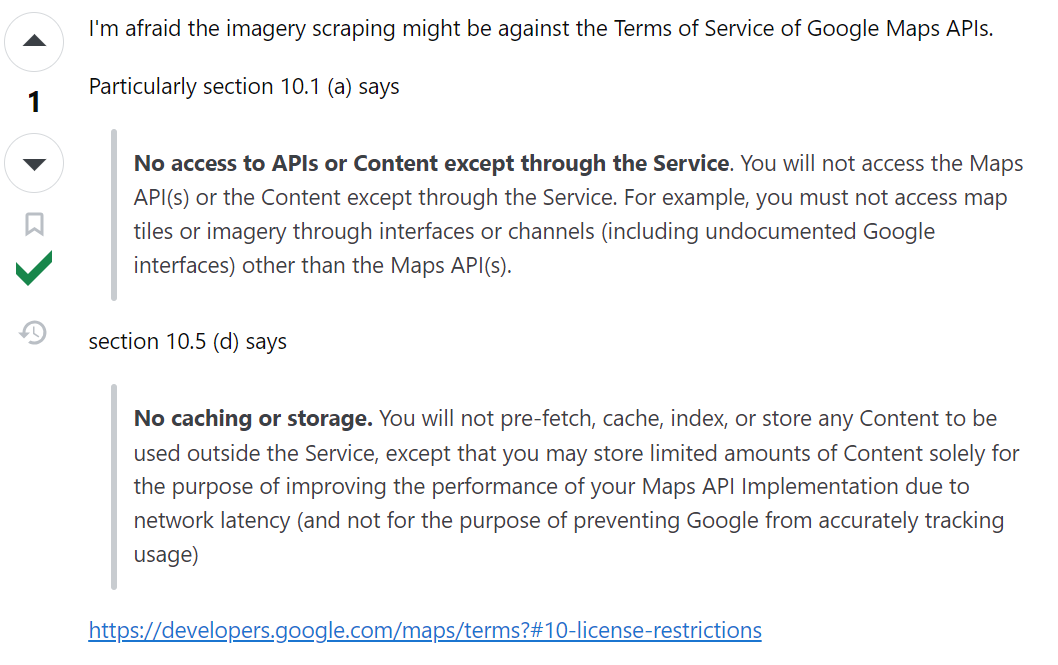

The Google Earth desktop however was found to have data of old images in the watch icon, but we are still perplexed how to exactly use it to get the images in our repo. Any ideas please mention in our issues section.

Given below is a complaint a user had regarding the same problem with having low quality images in GEE timeline option.

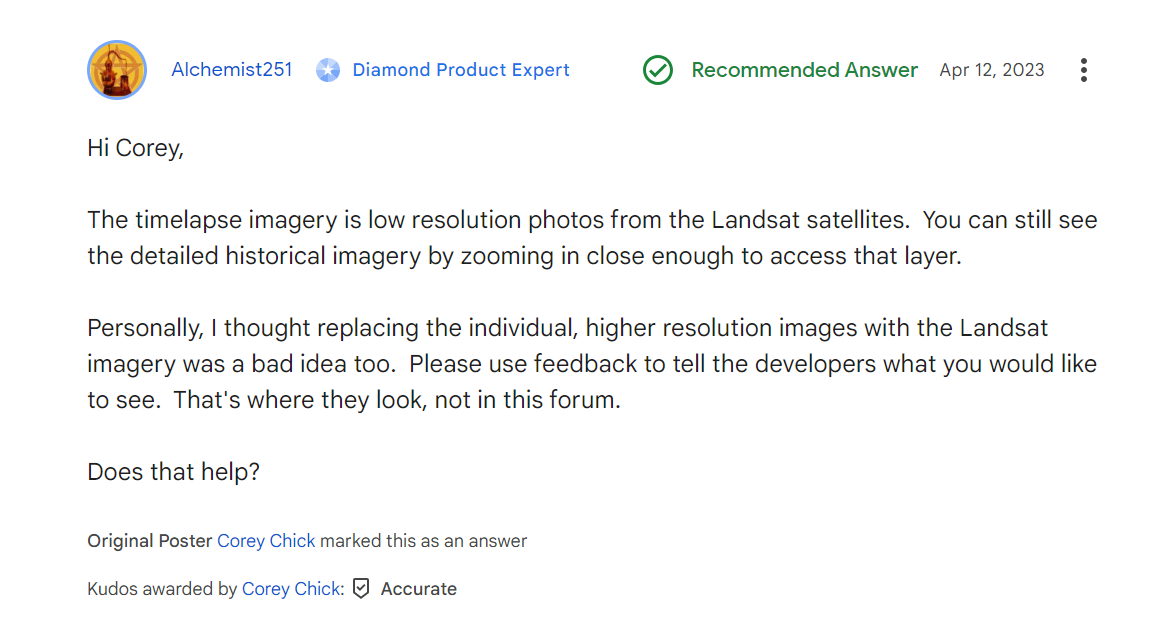

The code essentially downloads images in the 'png' format (although the format can be changed as a parameter ). After highly experimenting with all the parameters and asking gemini what the correct parameters are we finally arrived at something which was giving us a satisfactory output.
We have kept the other available parameters commented and always you can uncomment and recomment the parts of code to experiment and obtain the best results possible.

In [5]:
Map = geemap.Map()


region = Map.user_roi
region = ee.Geometry.Polygon(
    [
        [
            [74.80141895254025,12.836414341946114],
            [74.93737476308712,12.836414341946114],
            [74.93737476308712,12.956892699968696],
            [74.80141895254025,12.956892699968696],
            [74.80141895254025,12.836414341946114]
        ]
    ],
    None,
    False,
)

# region = Map.user_roi
# region = ee.Geometry.Polygon(
#     [
#         [
#             [74.83162248588447,12.86375720823081],
#            [74.84149301505927,12.86375720823081],
#            [74.84149301505927,12.873128804351786],
#            [74.83162248588447,12.873128804351786],
#            [74.83162248588447,12.86375720823081]
#         ]
#     ],
#     None,
#     False,
# )


image = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1")
    .filterBounds(region)
    .filterDate("2013", "2023")
    # .map(lambda img: img.select("B2","B3","B4").int())
    # , "Oa02_radiance", "Oa03_radiance", "Oa04_radiance", "Oa05_radiance", "Oa06_radiance", "Oa07_radiance", "Oa08_radiance", "Oa09_radiance", "Oa10_radiance", "Oa11_radiance", "Oa12_radiance", "Oa13_radiance", "Oa14_radiance", "Oa15_radiance", "Oa16_radiance", "Oa17_radiance", "Oa18_radiance", "Oa19_radiance", "Oa20_radiance", "Oa21_radiance", "quality_flags").int())
    .mosaic()
    # .median()
    .clip(region)
    .select("B2","B3","B4")
    #, "Oa02_radiance", "Oa03_radiance", "Oa04_radiance", "Oa05_radiance", "Oa06_radiance", "Oa07_radiance", "Oa08_radiance", "Oa09_radiance", "Oa10_radiance", "Oa11_radiance", "Oa12_radiance", "Oa13_radiance", "Oa14_radiance", "Oa15_radiance", "Oa16_radiance", "Oa17_radiance", "Oa18_radiance", "Oa19_radiance", "Oa20_radiance", "Oa21_radiance", "quality_flags")
)

# image = image.sort("CLOUD_COVER")

vis_params = {
    "bands": ["B4","B3","B2"],
    "min": 7000,
    "max": 15000,
    "gamma": 1.4
}

params = {
    "count": 14,  # How many image chips to export
    "buffer": 10000,  # The buffer distance (m) around each point
    "scale": 30,  # The scale to do stratified sampling
    "seed": 1,  # A randomization seed to use for subsampling.
    "dimensions": "512x512",  # The dimension of each image chip
    "format": "png",  # The output image format, can be png, jpg, ZIPPED_GEO_TIFF, GEO_TIFF, NPY
    "prefix": "tile_",  # The filename prefix
    "processes": 25,  # How many processes to used for parallel processing
    "out_dir": ".",  # The output directory. Default to the current working directly
}

def getRequests():
    img = ee.Image(1).rename("Class").addBands(image)
    points = img.stratifiedSample(
        numPoints=params["count"],
        region=region,
        scale=params["scale"],
        seed=params["seed"],
        geometries=True,
    )
    Map.data = points
    return points.aggregate_array(".geo").getInfo()


@retry(tries=10, delay=1, backoff=2)
def getResult(index, point):
    point = ee.Geometry.Point(point["coordinates"])
    region = point.buffer(params["buffer"]).bounds()

    if params["format"] in ["png", "jpg"]:
        url = image.getThumbURL(
            {
                "region": region,
                "dimensions": params["dimensions"],
                "format": params["format"],
                "min" : 7000,
                "max" : 15000,
                "gamma" : 1.4
            }
        )
    else:
        url = image.getDownloadURL(
            {
                "region": region,
                "dimensions": params["dimensions"],
                "format": params["format"],
            }
        )

    if params["format"] == "GEO_TIFF":
        ext = "tif"
    else:
        ext = params["format"]

    r = requests.get(url, stream=True)
    if r.status_code != 200:
        r.raise_for_status()

    out_dir = os.path.abspath(params["out_dir"])
    basename = str(index).zfill(len(str(params["count"])))
    filename = f"{out_dir}/{params['prefix']}{basename}.{ext}"
    with open(filename, "wb") as out_file:
        shutil.copyfileobj(r.raw, out_file)
    print("Done: ", basename)

# @retry(tries=10, delay=1, backoff=2)
# def getResult(index, point):
#     point = ee.Geometry.Point(point["coordinates"])
#     region = point.buffer(params["buffer"]).bounds()
#     url = image.getDownloadURL(
#         {
#             "region": region,
#             "dimensions": params["dimensions"],
#             "format": "GEO_TIFF",
#         }
#     )

#     ext = "tif"
#     r = requests.get(url, stream=True)
#     if r.status_code != 200:
#         r.raise_for_status()

#     out_dir = os.path.abspath(params["out_dir"])
#     basename = str(index).zfill(len(str(params["count"])))
#     filename = f"{out_dir}/{params['prefix']}{basename}.{ext}"
#     with open(filename, "wb") as out_file:
#         shutil.copyfileobj(r.raw, out_file)
#     print("Done: ", basename)

Map.addLayer(image, vis_params, "Least Cloudy")
Map.addLayer(region, {}, "ROI", False)
Map.setCenter(74.86321704824337,12.895322119464408)
# Map.setCenter(74.8362573430622,12.868610399939497)


logging.basicConfig()
items = getRequests()
print(items)

pool = multiprocessing.Pool(params["processes"])
pool.starmap(getResult, enumerate(items))

pool.close()

# Map.addLayer(Map.data, {})
# Map

[{'geodesic': False, 'type': 'Point', 'coordinates': [74.90345976774657, 12.92401707686335]}, {'geodesic': False, 'type': 'Point', 'coordinates': [74.85279478572222, 12.856912925139623]}, {'geodesic': False, 'type': 'Point', 'coordinates': [74.84093702397185, 12.936683322369436]}, {'geodesic': False, 'type': 'Point', 'coordinates': [74.8075196954026, 12.84667213090066]}, {'geodesic': False, 'type': 'Point', 'coordinates': [74.92124641037213, 12.92994595773854]}, {'geodesic': False, 'type': 'Point', 'coordinates': [74.92987023709968, 12.895989639998822]}, {'geodesic': False, 'type': 'Point', 'coordinates': [74.89591391935996, 12.955547943335946]}, {'geodesic': False, 'type': 'Point', 'coordinates': [74.93552962338963, 12.905421950482078]}, {'geodesic': False, 'type': 'Point', 'coordinates': [74.8180299842268, 12.880628448640378]}, {'geodesic': False, 'type': 'Point', 'coordinates': [74.88729009263241, 12.84801960382684]}, {'geodesic': False, 'type': 'Point', 'coordinates': [74.893218973

Done:  05
Done:  11
Done:  04
Done:  12
Done:  09
Done:  03
Done:  07
Done:  06
Done:  01
Done:  02
Done:  08
Done:  10
Done:  13
Done:  00


Below is a sample image we found for the Mangaluru coordinates and region we selected

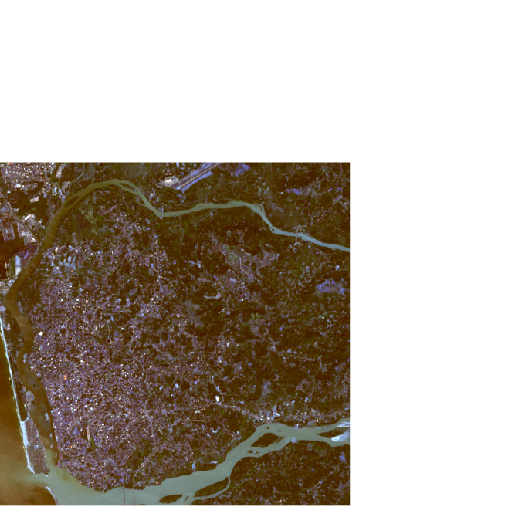

In [6]:
from PIL import Image

img = Image.open('/content/tile_00.png')
display(img)

Get the map with least clouds. Although the map was generated we didnt attempt to extract the image to save and process because the images Landsat threw were of very low quality when zoomed and since our use-case deals with an extensive study in particular to local waterbodies and greenery , the amount of precision we would obtain from images such as given below would be really shallow.

In [7]:
Map = geemap.Map()


region = Map.user_roi
region = ee.Geometry.Polygon(
    [
        [
            [74.80141895254025,12.836414341946114],
            [74.93737476308712,12.836414341946114],
            [74.93737476308712,12.956892699968696],
            [74.80141895254025,12.956892699968696],
            [74.80141895254025,12.836414341946114]
        ]
    ],
    None,
    False,
)

The least cloudy image is shown below

In [10]:
col = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")
    .filterBounds(region)
    .filterDate("2019", "2020")
)

display('Collection', col)

# Sort the collection in ASCENDING order of image cloud cover.
col_cld_sort_asc = col.sort('CLOUD_COVER')
# display('Cloud cover ascending', col_cld_sort_asc)

# Display the image with the least cloud cover.
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0.01, 'max': 0.25}
m = geemap.Map()
m.set_center(74.87409032010902,12.885417766069935)
m.add_layer(col_cld_sort_asc.first(), vis_params, 'Least cloudy')

m

'Collection'

Map(center=[12.885417766069935, 74.87409032010902], controls=(WidgetControl(options=['position', 'transparent_…

The following image is of the most clouded image in the given timeframe


In [9]:
# Sort the collection in DESCENDING order of image cloud cover.
col_cld_sort_desc = col.sort('CLOUD_COVER', False)
display('Cloud cover descending', col_cld_sort_desc)

# Display the image with the most cloud cover.
m.add_layer(col_cld_sort_desc.first(), vis_params, 'Most cloudy')
m

'Cloud cover descending'

Map(center=[12.885417766069935, 74.87409032010902], controls=(WidgetControl(options=['position', 'transparent_…